In [45]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
import seaborn as sns

import scipy
# from keras.preprocessing.image import ImageDataGenerator

In [46]:
RANDOM_STATE=42
MODEL_NAME="7_class_emotion_detector_no_transformations"
BATCH_SIZE = 64
EPOCHS = 30
CLASSES = 7
ROWS,COLUMNS=48,48

In [47]:
files_path = "./FinalProjData"

int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise',6:'disgust'}
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5,'disgust':6}

dic = {'images':[], 'labels':[], 'purpose':[], 'image_path':[]}

for d in os.listdir(f'{files_path}/fer2013/'):
    print(d)
    for emotion in os.listdir(f'{files_path}/fer2013/{d}'):
        print('\t\t' + emotion)
        for i in os.listdir(f'{files_path}/fer2013/{d}/{emotion}'):
            img = cv2.imread(f'{files_path}/fer2013/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)

            dic['images'].append(img)
            dic['labels'].append(emotion)
            dic['image_path'].append(f'{files_path}/fer2013/{d}/{emotion}/{i}')

            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('S')

df = pd.DataFrame(dic)
df.head()

test
		angry
		disgust
		fear
		happy
		neutral
		sad
		surprise
train
		angry
		disgust
		fear
		happy
		neutral
		sad
		surprise


,images,labels,purpose,image_path
0,"[[[46], [34], [26], [23], [12], [32], [35], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
1,"[[[55], [33], [54], [32], [26], [21], [50], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
2,"[[[123], [123], [126], [131], [124], [69], [10...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
3,"[[[255], [255], [255], [255], [255], [255], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
4,"[[[127], [121], [124], [137], [123], [118], [1...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...


In [48]:
train_data = df[df['purpose']=='T'].sample(frac=0.8, random_state=RANDOM_STATE)
val_data = df[df['purpose']=='T'].drop(train_data.index, axis=0)
test_data = df[df['purpose']=='S']

In [49]:
len(train_data)

22967

In [50]:
train_data['labels'].value_counts()

labels
happy       5813
neutral     3965
sad         3834
fear        3284
angry       3218
surprise    2490
disgust      363
Name: count, dtype: int64

In [51]:
val_data['labels'].value_counts()

labels
happy       1402
neutral     1000
sad          996
fear         813
angry        777
surprise     681
disgust       73
Name: count, dtype: int64

In [52]:
happy_df = train_data[train_data['labels']=='happy']
neutral_df = train_data[train_data['labels']=='neutral']
sad_df = train_data[train_data['labels']=='sad']
fear_df = train_data[train_data['labels']=='fear']
angry_df = train_data[train_data['labels']=='angry']
surprise_df = train_data[train_data['labels']=='surprise']
disgust_df = train_data[train_data['labels']=='disgust']

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df, disgust_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose,image_path
0,"[[[199], [204], [201], [199], [202], [196], [1...",sad,T,./FinalProjData/fer2013/train/sad/Training_843...
1,"[[[48], [51], [52], [56], [55], [60], [60], [6...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...
2,"[[[53], [91], [73], [40], [50], [64], [39], [4...",sad,T,./FinalProjData/fer2013/train/sad/Training_530...
3,"[[[69], [58], [58], [62], [70], [70], [60], [2...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...
4,"[[[40], [41], [39], [33], [43], [43], [39], [4...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...


In [53]:
train_data['labels'].value_counts()

labels
happy       5813
neutral     3965
sad         3834
fear        3284
angry       3218
surprise    2490
disgust      363
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

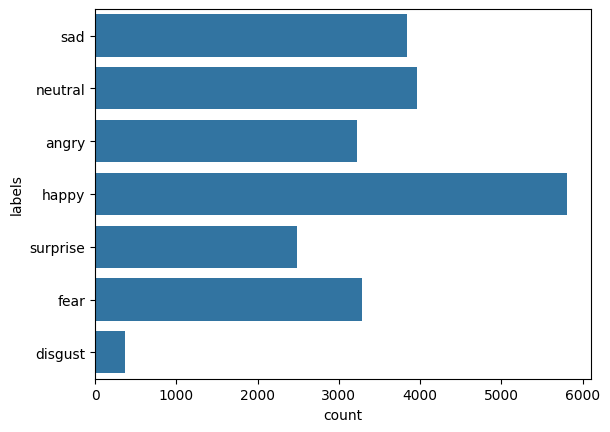

In [54]:
sns.countplot(train_data['labels'])

In [55]:
val_data['labels'].value_counts()

labels
happy       1402
neutral     1000
sad          996
fear         813
angry        777
surprise     681
disgust       73
Name: count, dtype: int64

In [56]:
# Convert dataframe to numpy array
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [57]:
train_data.shape

(22967, 48, 48, 1)

In [58]:
val_data.shape

(5742, 48, 48, 1)

In [59]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(ROWS,COLUMNS,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(ROWS,COLUMNS,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(CLASSES,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_22 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_23 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

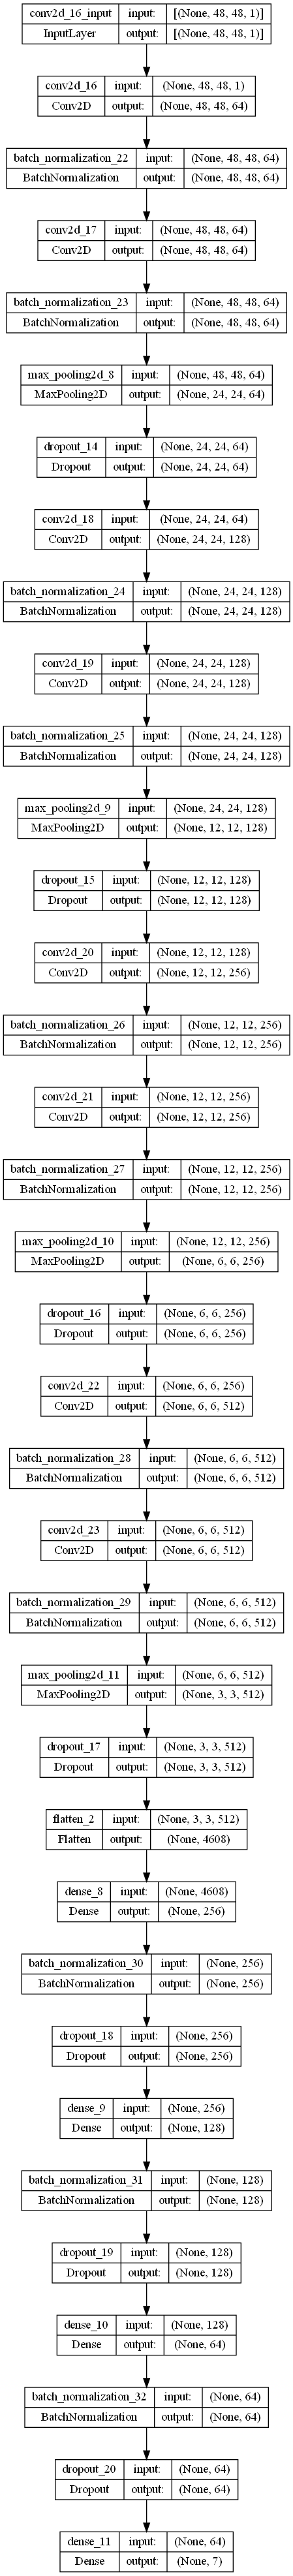

In [60]:
from keras.utils import plot_model
import IPython.display


# Plot and save the model graph
plot_model(model, show_shapes=True, to_file=f'{files_path}/model/{MODEL_NAME}.png', rankdir='TB')
IPython.display.Image(f'{files_path}/model/{MODEL_NAME}.png')

In [61]:
checkpoint = ModelCheckpoint(f'{files_path}/model/{MODEL_NAME}.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

In [62]:
train_samples = len(train_data)
validation_samples = len(val_data)

In [64]:
history = model.fit(train_data,
                    train_labels,
                    epochs=EPOCHS,
                    steps_per_epoch=train_samples//BATCH_SIZE,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//BATCH_SIZE,
                    callbacks=callbacks)

Epoch 1/30
358/358 [==============================] - ETA: 0s - loss: 2.3162 - accuracy: 0.1853
Epoch 1: val_loss improved from inf to 2.07533, saving model to ./FinalProjData/model\7_class_emotion_detector_no_transformations.h5
358/358 [==============================] - 35s 67ms/step - loss: 2.3162 - accuracy: 0.1853 - val_loss: 2.0753 - val_accuracy: 0.1989
Epoch 2/30
358/358 [==============================] - ETA: 0s - loss: 1.8421 - accuracy: 0.2556
Epoch 2: val_loss improved from 2.07533 to 1.70067, saving model to ./FinalProjData/model\7_class_emotion_detector_no_transformations.h5
358/358 [==============================] - 23s 64ms/step - loss: 1.8421 - accuracy: 0.2556 - val_loss: 1.7007 - val_accuracy: 0.3150
Epoch 3/30
358/358 [==============================] - ETA: 0s - loss: 1.5239 - accuracy: 0.4080
Epoch 3: val_loss improved from 1.70067 to 1.43651, saving model to ./FinalProjData/model\7_class_emotion_detector_no_transformations.h5
358/358 [==============================

<Axes: >

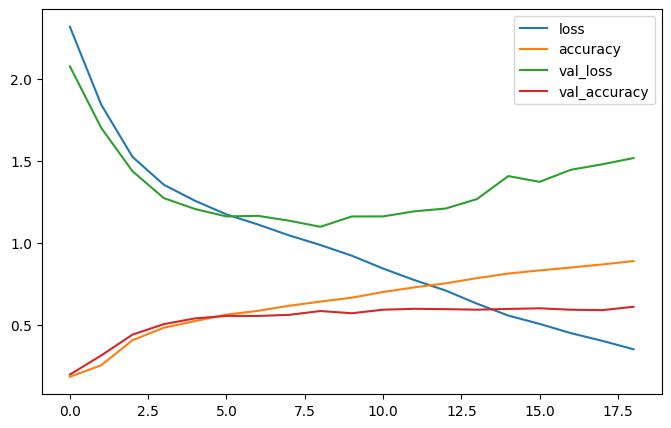

In [65]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [82]:
test_predictions = model.predict(np.array(list(test_data['images'])))
labeled_predictions = [int2emotions[i] for i in np.argmax(test_predictions, axis=-1)]
prediction_accuracy = sum(test_data['labels'] == labeled_predictions) / len(test_data)
print(f'Prediction Accuracy: {prediction_accuracy}')

225/225 [==============================] - 2s 11ms/step
Prediction Accuracy: 0.5930621342992477
